In [1]:
import copy
import time
import os 
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from scipy import io as sio
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.model_selection import train_test_split
from pprint import pprint

## k-Neasrest Neighbour (kNN) Classifier analysis

In this notebook, we compute the k-Nearest Neighbor (kNN) classifier accuracy results for the raw data for the frequency selective ROIs for each brain region and choose the optimal k to be used for a further step where we compute the kNN for the same dataset, but with uniformly random reassignment of frequency labels. This is done in order to evaluate whether the dataset shows specific non-random spatial distribution of frequency selective ROIs.

In [2]:
mat_fpath = r'20200804_ROI_per_brain_region_to_python_25sd_wmergedsides_FINAL.mat'
zero_to_add_fpath = r'E:\PhD\BWAP\zero_only_labels_to_add.mat'
folder_path = os.path.split(mat_fpath)[0]

Adding 0 labels to Cerebellum:
Working on the Cerebellum
The optimal K is 6


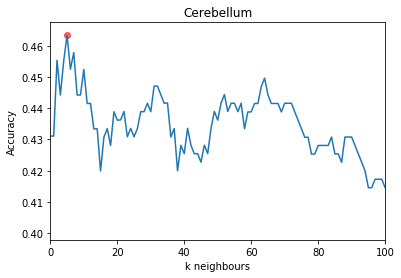

Adding 0 labels to Hindbrain:
Working on the Hindbrain
The optimal K is 10


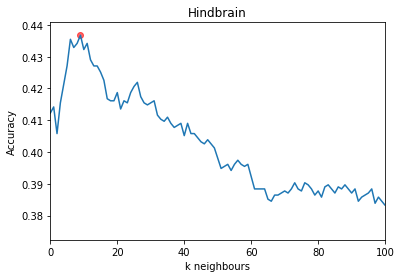

Adding 0 labels to OLN:
Working on the OLN
The optimal K is 6


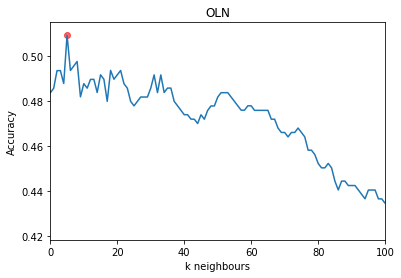

Adding 0 labels to TS:
Working on the TS
The optimal K is 91


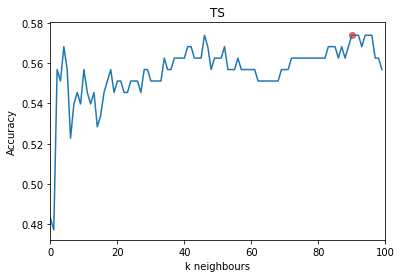

Adding 0 labels to Tectum:
Working on the Tectum
The optimal K is 7


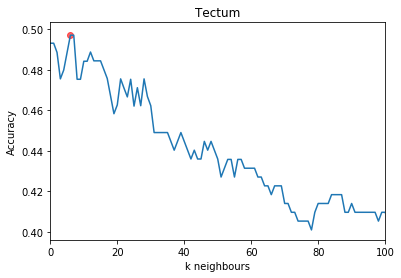

Adding 0 labels to Tegmentum:
Working on the Tegmentum
The optimal K is 27


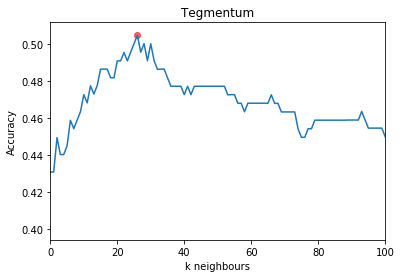

Adding 0 labels to Telencephalon:
Working on the Telencephalon
The optimal K is 12


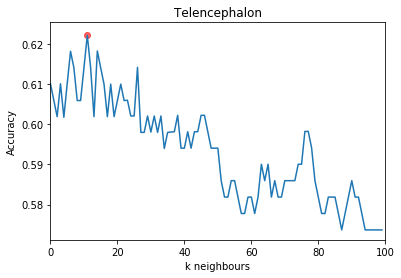

In [3]:
#load roi mat files 
ROIS = sio.loadmat(mat_fpath)
# load mat file with coordinates around the brain region with `0` labels 
zero_to_add = sio.loadmat(zero_to_add_fpath)

metadata = ['__header__', '__version__', '__globals__']

# cross-validation K-fold split is 10, unless the minimum number of rois for a single frequency (k) is lower, then use k 
cv_split = {'Cerebellum' : 10, 'Hindbrain' : 10, 'Tectum' : 10, 'OLN' : 10, 'TS': 4, 'Telencephalon': 5, 'Tegmentum' : 4}

# save optimal k value for the keys in ROIs
cv_results_dict = {}

for key, value in ROIS.items():
    if key not in metadata: 
        print("Adding 0 labels to {}:".format(key))
        value = np.vstack((value, np.array(list(zero_to_add[key]),dtype='int32')))
        
        # find optimal radius for RNC
        print('Working on the', key)
        neighbors_list = list(range(1,150,1))
        cv_scores = [ ]
        for K in neighbors_list:
            if (key == 'Telencephalon' or key == 'TS')and K > 100:
                pass
            else:
                knn =  KNeighborsClassifier(n_neighbors = K, weights='distance')
                scores = cross_val_score(knn, value[:,0:3], value[:,-1], cv=cv_split[key], scoring="accuracy")
                cv_scores.append(scores.mean())

        # Changing to misclassification error
        mse = [1-x for x in cv_scores]
        # determing best k
        optimal_k = neighbors_list[mse.index(min(mse))]
        cv_results_dict.update({key : {'opt_k' : optimal_k, 'scores' : cv_scores}})
        print("The optimal K is {}".format(optimal_k))

        # print results and point out the optimal (red) in the plot as well as the chosen radius (green)
        plt.plot(cv_scores)
        plt.scatter(optimal_k-1,cv_scores[optimal_k-1], c='red', alpha=0.6)
        plt.xlim([0,100])
        plt.title(key)
        plt.ylabel('Accuracy')
        plt.xlabel('k neighbours')
        plt.show()
        

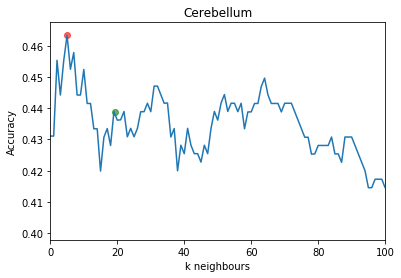

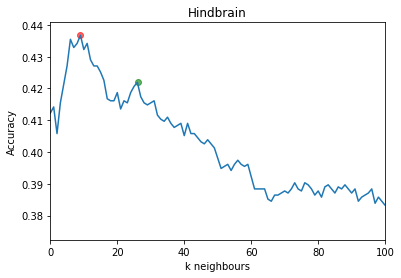

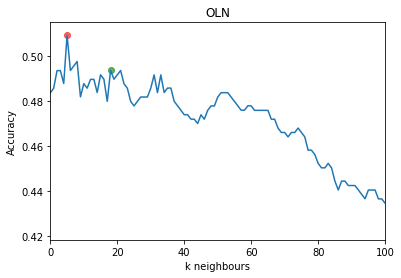

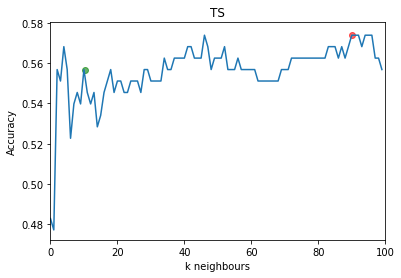

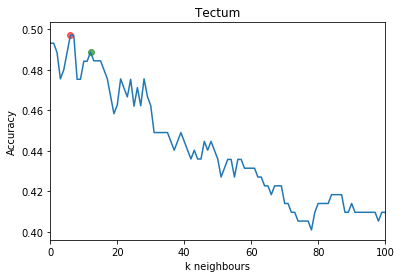

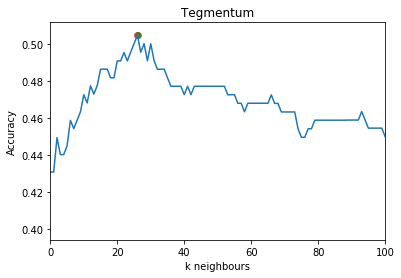

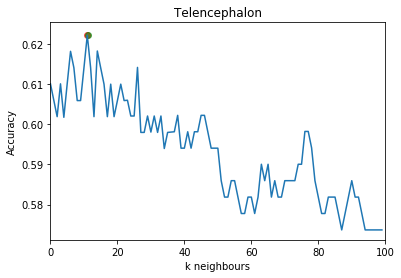

In [4]:
# In the first run, the values below are likely to be incorrect, change them to plot the chosen k for further steps
# these are the k values to be used in the further analyses (same as in the previous cell)
k_neighbors = {'Cerebellum' : 20, 'Hindbrain' : 27, 'Tectum' : 13, 'OLN' : 19, 'TS': 11, 'Telencephalon': 12, 'Tegmentum' : 27}

for key, value in ROIS.items():
    if key not in metadata: 
        # print results and point out the optimal (red) in the plot as well as the chosen radius (green)
        plt.plot(cv_results_dict[key]['scores'])
        plt.scatter(cv_results_dict[key]['opt_k']-1,cv_results_dict[key]['scores'][cv_results_dict[key]['opt_k']-1], c='red', alpha=0.6)
        plt.scatter(k_neighbors[key]-0.8,cv_results_dict[key]['scores'][k_neighbors[key]-1], c='green', alpha=0.6)
        plt.xlim([0,100])
        plt.title(key)
        plt.ylabel('Accuracy')
        plt.xlabel('k neighbours')
        plt.show()

With the results shown above, we were able to choose a value of k for each brain region that would reoughly optimal to then obtain the fraction of neighbors from each frequency for a determined main frequency (e.g. what is the fraction of 250, 500, and 750 Hz neighbors do the 100 Hz ROIs have?). As you may have seen, the k chosen was not necessarily the one that yielded the highest accuracy (in most cases the accuracy does not even vary considerably, being within a range +- 0.05) as we also want to reduce variability of the fraction calculated by chosing a k that is not too small. Our criteria was to choose a k higher than 10 but lower than 20% of the total number of ROIs in that brain region.  

In [5]:
#reload rois since I added points to MON in previous cells
ROIS = sio.loadmat(mat_fpath)

metadata = ['__header__', '__version__', '__globals__']

# create a dictionary to store fractions of neighbouring ROIs per frequency and a summary dictionary with 
# the mean and std value calculated based on the number of ROIs per frequency
neighbor_dist = {}
neighbor_dist_summary = {}

# setup the dictionary so its keys are brain regions in ROIS.keys() and value is a another dictionary
for key, value in ROIS.items():
    if key not in metadata: 
        neighbor_dist.update({key : {}})
        neighbor_dist_summary.update({key : {}})
        
        labels = np.unique(value[:,-1])
        for label in labels:
            neighbor_dist[key].update({str(label) : None})
            neighbor_dist_summary[key].update({str(label) : {}})

start = time.time()
for key, value in ROIS.items():
    if key not in metadata: 
        # compute distances 
        distances = squareform(pdist(value[:,0:3]))
        print(key, 'shape')
        print(value[:,0:3].shape)
        #print(distances.shape)
        #plt.imshow(distances)
        #plt.show()
        
        labels = np.unique(value[:,-1])
        print('frequencies present in this brain region:')
        print(labels)
        
        for label in labels:
            distances_single_freq = distances[value[:,-1]==label,:]      
            #print(key,label)
            #plt.imshow(distances_single_freq)
            #plt.show()
            for roi in distances_single_freq: 
                # get the k-nearest neighbors
                sorted_dist = np.sort(roi)[1:k_neighbors[key]+1]
                # get indices of these neighbors and then get their frequency label
                indices = np.asarray([True if dist in sorted_dist else False for dist in roi])
                neighbor_labels = value[indices,-1]
                #print(neighbor_labels)
                # count the number of occurrences for each label in the k neighbors of this particular roi
                counter = np.reshape(np.asarray([sum(neighbor_labels == label) for label in labels]),(1,-1))
                #print(counter)
                #print(counter.shape)
                if neighbor_dist[key][str(label)] is None:
                    neighbor_dist[key][str(label)] = counter / k_neighbors[key]
                else:
                    neighbor_dist[key][str(label)] = np.vstack((neighbor_dist[key][str(label)], counter / k_neighbors[key]))
        
            neighbor_dist_summary[key][str(label)].update({'mean' : np.mean(neighbor_dist[key][str(label)], axis=0), 'std' : np.std(neighbor_dist[key][str(label)], axis=0)})
end = time.time()
print("elapsed time: {}".format(end-start))

# verify results 
pprint(neighbor_dist_summary)

Cerebellum shape
(359, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
Hindbrain shape
(1537, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
OLN shape
(501, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
TS shape
(166, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2500]
Tectum shape
(219, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
Tegmentum shape
(208, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
Telencephalon shape
(236, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
elapsed time: 8.324454307556152
{'Cerebellum': {'100': {'mean': array([0.10277778, 0.04722222, 0.06388889, 0.23888889, 0.15      ,
       0.18611111, 0.10555556, 0.10555556]),
                        'std': array([0.05645112, 0.08575194, 0.04656404, 0.

In [6]:
#Perform the exact same procedure, but with a labels assigned randomly (with an uniform distribution)
neighbor_dist_rand = {}
neighbor_dist_rand_summary = {}
for key, value in ROIS.items():
    if key not in metadata: 
        neighbor_dist_rand.update({key : {}})
        neighbor_dist_rand_summary.update({key : {}})
        
        labels = np.unique(value[:,-1])
        for label in labels:
            neighbor_dist_rand[key].update({str(label) : None})
            neighbor_dist_rand_summary[key].update({str(label) : {}})

In [7]:
# choose the number of time you wish to run the randomized nearest neighbors 
n_iter = 50

start = time.time()

for key, value in ROIS.items():
    if key not in metadata: 
        for k in range(n_iter):
            # generate a set of indices with an uniform distribution for each iteration 
            # only done once in the first run, number of columns have size n_iter
            if k == 0:
                rand_indices = np.random.randint(0,high=len(value),size=(len(value),n_iter))
            # compute distances 
            distances = squareform(pdist(value[:,0:3]))
            #print(value[:,0:3].shape)
            #print(distances.shape)
            #plt.imshow(distances)
            #plt.show()

            labels = np.array([100, 250, 500, 750, 1000, 1500, 2000, 2500])
            if key == 'TS':
                labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])

            # Reassign labels to ROIs
            rand_idx = rand_indices[:,k]
            #print('before')
            #print(value[:,-1])
            new_labels = value[rand_idx,-1]
            #print('after')
            #print(value[:,-1])
            for label in labels:
                #print(key)
                #print('label:', str(label))
                distances_single_freq = distances[new_labels==label,:]      
                
                for roi in distances_single_freq: 
                    #get the k nearest neighbors
                    sorted_dist = np.sort(roi)[1:k_neighbors[key]+1]
                    indices = np.asarray([True if dist in sorted_dist else False for dist in roi])
                    neighbor_labels = value[indices,-1]
                    #print(neighbor_labels)
                    #if key == 'Telencephalon':
                    #    print(labels)
                    #    print(value)
                    # count the number of occurrences for each label in the k neighbors of this particular roi
                    counter = np.reshape(np.asarray([sum(neighbor_labels == label) for label in labels]),(1,-1))
                    #print(counter)
                    #print(counter)
                    #print(counter.shape)
                    if neighbor_dist_rand[key][str(label)] is None:
                        neighbor_dist_rand[key][str(label)] = counter / k_neighbors[key]
                    else:
                        neighbor_dist_rand[key][str(label)] = np.vstack((neighbor_dist_rand[key][str(label)], counter / k_neighbors[key]))

                if not neighbor_dist_rand_summary[key][str(label)]:    
                    neighbor_dist_rand_summary[key][str(label)].update({'mean' : np.mean(neighbor_dist_rand[key][str(label)], axis=0), 'std' : np.std(neighbor_dist_rand[key][str(label)], axis=0)})
                else:
                    neighbor_dist_rand_summary[key][str(label)]['mean'] = np.vstack((neighbor_dist_rand_summary[key][str(label)]['mean'] ,np.mean(neighbor_dist_rand[key][str(label)], axis=0)))
                    neighbor_dist_rand_summary[key][str(label)]['std'] = np.vstack((neighbor_dist_rand_summary[key][str(label)]['std'] ,np.std(neighbor_dist_rand[key][str(label)], axis=0)))
            if k%100 == 0:
                print(str(k),'-th iteration')
            if k%25 == 0:
                print("gone through {} in {}-th iteration with {} seconds elapsed...".format(key , str(k), str(time.time()-start)))
end = time.time()
print("elapsed time: {}".format(end-start))


0 -th iteration
gone through Cerebellum in 0-th iteration with 0.422243595123291 seconds elapsed...
gone through Cerebellum in 25-th iteration with 11.005217552185059 seconds elapsed...
0 -th iteration
gone through Hindbrain in 0-th iteration with 27.66020941734314 seconds elapsed...
gone through Hindbrain in 25-th iteration with 187.81983876228333 seconds elapsed...
0 -th iteration
gone through OLN in 0-th iteration with 343.58377385139465 seconds elapsed...
gone through OLN in 25-th iteration with 362.79189586639404 seconds elapsed...
0 -th iteration
gone through TS in 0-th iteration with 381.1552515029907 seconds elapsed...
gone through TS in 25-th iteration with 383.54416966438293 seconds elapsed...
0 -th iteration
gone through Tectum in 0-th iteration with 386.01678800582886 seconds elapsed...
gone through Tectum in 25-th iteration with 390.1197774410248 seconds elapsed...
0 -th iteration
gone through Tegmentum in 0-th iteration with 394.2382700443268 seconds elapsed...
gone throu

In [8]:
#verify results
print(neighbor_dist_rand_summary)

#create new dictionary so save summarized version of the randomized results, 
# as there are n_iter values of the fractions of neighbors
neighbor_dist_rand_mean_summary = copy.copy(neighbor_dist_rand_summary)

{'Cerebellum': {'100': {'mean': array([[0.075     , 0.08333333, 0.06388889, 0.21388889, 0.11666667,
        0.26944444, 0.05833333, 0.11944444],
       [0.05606061, 0.08333333, 0.07121212, 0.25909091, 0.15151515,
        0.20757576, 0.05909091, 0.11363636],
       [0.05581395, 0.07906977, 0.06744186, 0.2627907 , 0.1755814 ,
        0.19883721, 0.05813953, 0.10465116],
       [0.04642857, 0.08142857, 0.075     , 0.24142857, 0.16785714,
        0.22785714, 0.06714286, 0.09571429],
       [0.05117647, 0.07823529, 0.07470588, 0.22764706, 0.17941176,
        0.21882353, 0.07647059, 0.09705882],
       [0.05631068, 0.0723301 , 0.07572816, 0.22330097, 0.18300971,
        0.2276699 , 0.06796117, 0.09708738],
       [0.05614754, 0.07540984, 0.07622951, 0.21844262, 0.1692623 ,
        0.24221311, 0.06188525, 0.10368852],
       [0.05814815, 0.07592593, 0.07777778, 0.21259259, 0.1762963 ,
        0.23666667, 0.06      , 0.10555556],
       [0.05782313, 0.07517007, 0.07755102, 0.21870748, 0.172448

In [9]:
condensed_rand_summary = {}
condensed_summary = {}
# mean of the means 
# here you will find some hard coded computations to compute a summarized and tidy version of the results and store in 
# condensed_rand_summary and condensed_summary
for brain_region, frequencies_dicts in neighbor_dist_rand_summary.items():
    condensed_rand_summary.update({brain_region : {'mean': None, 'std' : None}})
    condensed_summary.update({brain_region : {'mean': None, 'std' : None}})
    
    if key == 'TS':
        df_rand = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2500'])
        df = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2500'])
        df_rand_std = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2500'])
        df_std = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2500'])
    else:
        df_rand = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2000', '2500'])
        df = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2000', '2500'])
        df_rand_std = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2000', '2500'])
        df_std = pd.DataFrame(columns = ['100', '250', '500', '750', '1000', '1500', '2000', '2500'])
        
    for freq, mean_std_dict in neighbor_dist_rand_summary[brain_region].items():
        df_rand[freq] = copy.copy(np.mean(neighbor_dist_rand_summary[brain_region][freq]['mean'], axis=0)).T
        df[freq] = neighbor_dist_summary[brain_region][freq]['mean'].T
        df_rand_std[freq] = copy.copy(np.mean(neighbor_dist_rand_summary[brain_region][freq]['std'], axis=0)).T
        df_std[freq] = neighbor_dist_summary[brain_region][freq]['std'].T
        
        for variable, values in neighbor_dist_rand_summary[brain_region][freq].items():
            #print(brain_region, freq, variable)
            #print(np.mean(neighbor_dist_rand_summary[brain_region][freq][variable], axis=0))
            neighbor_dist_rand_mean_summary[brain_region][freq][variable] = np.mean(neighbor_dist_rand_summary[brain_region][freq][variable], axis=0)
        
    condensed_rand_summary[brain_region]['mean'] = df_rand
    condensed_summary[brain_region]['mean'] = df
    condensed_rand_summary[brain_region]['std'] = df_rand_std
    condensed_summary[brain_region]['std'] = df_std
    

### Please note that, in the following cells, the last lines save some results, comment those lines if you don't want to overwrite previous results 

Cerebellum
    freq main_freq  fraction
0    100       100  0.102778
1    250       100  0.047222
2    500       100  0.063889
3    750       100  0.238889
4   1000       100  0.150000
..   ...       ...       ...
59   750      2500  0.115152
60  1000      2500  0.143939
61  1500      2500  0.306061
62  2000      2500  0.050000
63  2500      2500  0.139394

[64 rows x 3 columns]


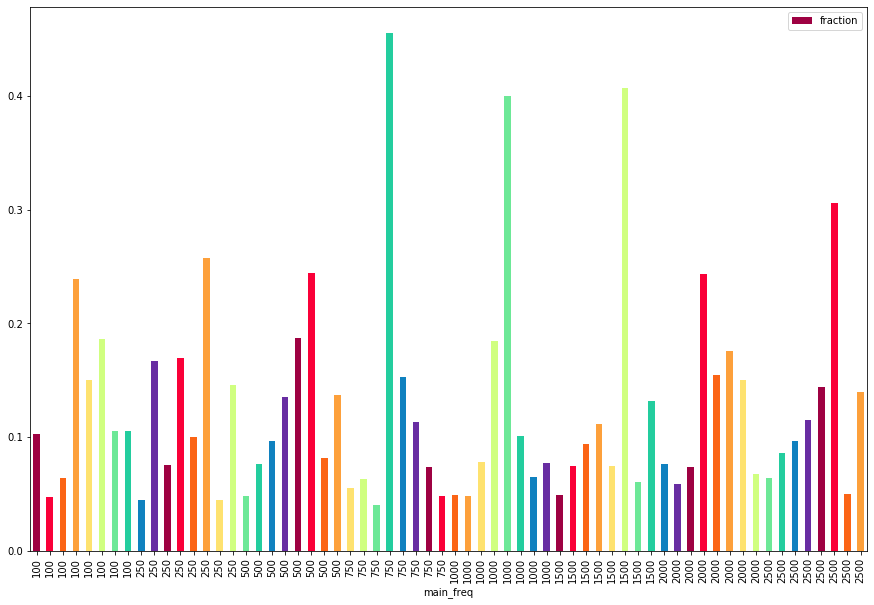

Hindbrain
    freq main_freq  fraction
0    100       100  0.201245
1    250       100  0.149131
2    500       100  0.062602
3    750       100  0.216650
4   1000       100  0.113405
..   ...       ...       ...
59   750      2500  0.192791
60  1000      2500  0.112103
61  1500      2500  0.223545
62  2000      2500  0.076720
63  2500      2500  0.136574

[64 rows x 3 columns]


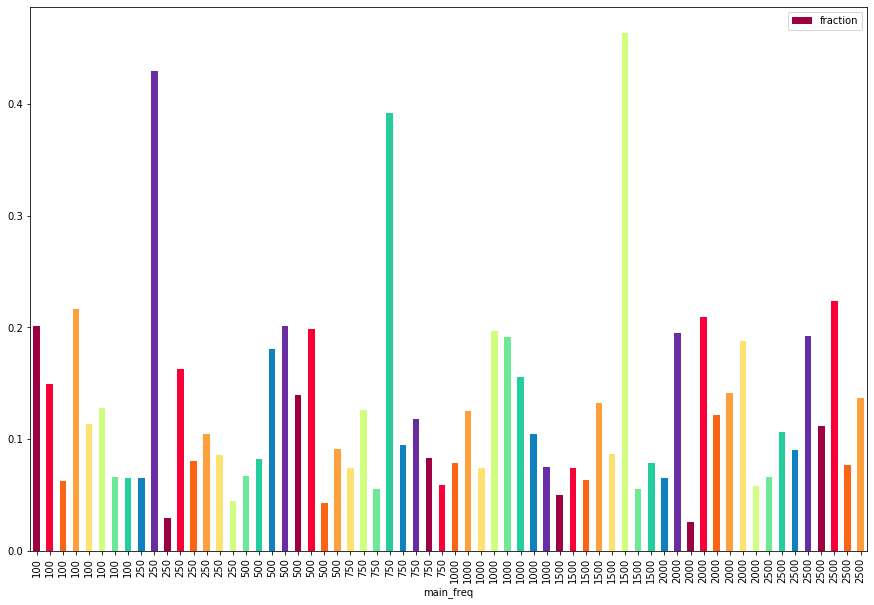

OLN
    freq main_freq  fraction
0    100       100  0.086957
1    250       100  0.125858
2    500       100  0.137300
3    750       100  0.228833
4   1000       100  0.082380
..   ...       ...       ...
59   750      2500  0.299342
60  1000      2500  0.057018
61  1500      2500  0.078947
62  2000      2500  0.030702
63  2500      2500  0.223684

[64 rows x 3 columns]


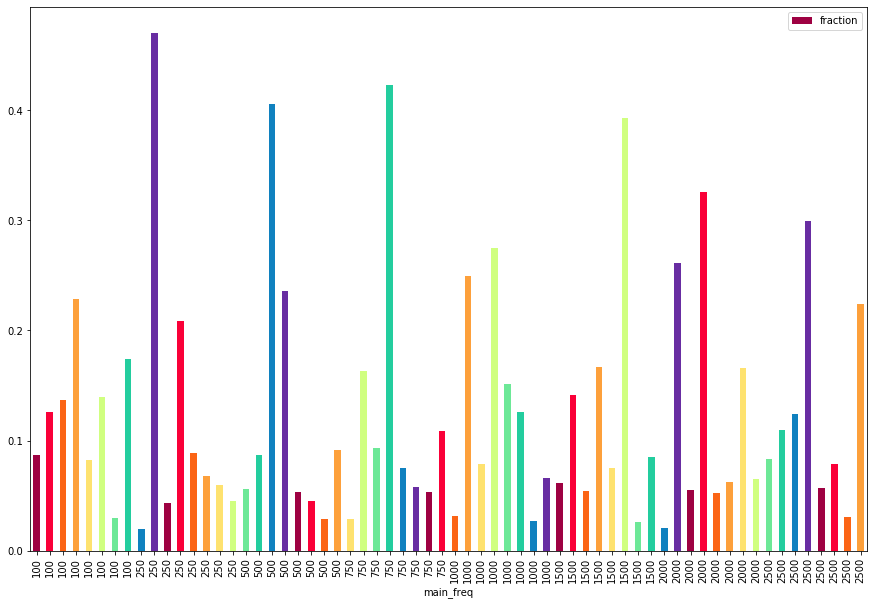

TS
    freq main_freq    fraction
0    100       100   0.0363636
1    250       100    0.418182
2    500       100   0.0363636
3    750       100         0.4
4   1000       100   0.0363636
5   1500       100           0
6   2500       100   0.0909091
7    100       250   0.0454545
8    250       250    0.557851
9    500       250   0.0578512
10   750       250    0.258264
11  1000       250   0.0268595
12  1500       250  0.00826446
13  2500       250   0.0495868
14   100       500    0.020202
15   250       500    0.323232
16   500       500    0.171717
17   750       500    0.313131
18  1000       500    0.010101
19  1500       500    0.131313
20  2500       500    0.030303
21   100       750   0.0287687
22   250       750    0.171461
23   500       750   0.0299194
24   750       750    0.601841
25  1000       750   0.0333717
26  1500       750   0.0529344
27  2500       750   0.0863061
28   100      1000   0.0227273
29   250      1000        0.25
30   500      1000   0.0227273
31   

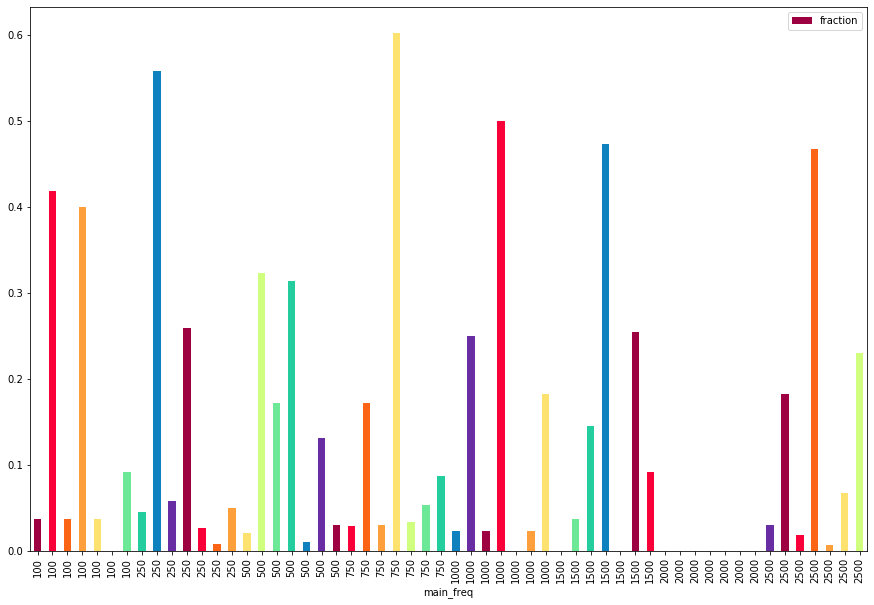

Tectum
    freq main_freq  fraction
0    100       100  0.170040
1    250       100  0.396761
2    500       100  0.149798
3    750       100  0.056680
4   1000       100  0.040486
..   ...       ...       ...
59   750      2500  0.064685
60  1000      2500  0.194056
61  1500      2500  0.047203
62  2000      2500  0.045455
63  2500      2500  0.234266

[64 rows x 3 columns]


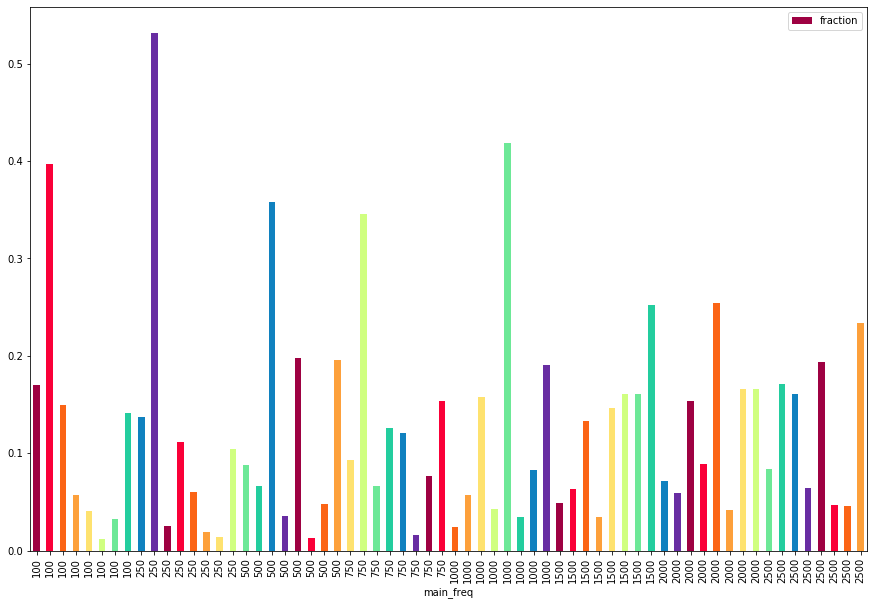

Tegmentum
    freq main_freq  fraction
0    100       100  0.069444
1    250       100  0.055556
2    500       100  0.092593
3    750       100  0.287037
4   1000       100  0.300926
..   ...       ...       ...
59   750      2500  0.324074
60  1000      2500  0.101852
61  1500      2500  0.194444
62  2000      2500  0.009259
63  2500      2500  0.055556

[64 rows x 3 columns]


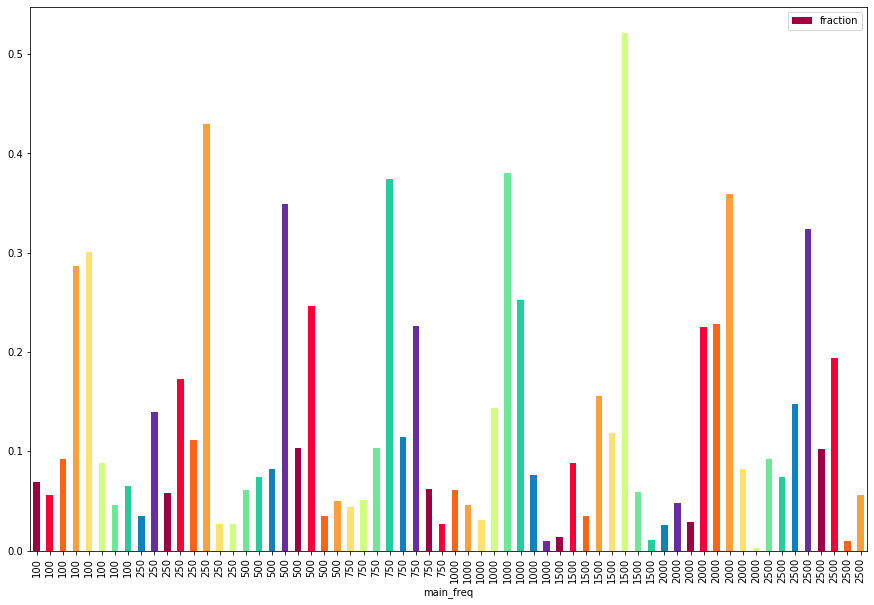

Telencephalon
    freq main_freq  fraction
0    100       100  0.317308
1    250       100  0.028846
2    500       100  0.160256
3    750       100  0.038462
4   1000       100  0.032051
..   ...       ...       ...
59   750      2500  0.061404
60  1000      2500  0.012427
61  1500      2500  0.023392
62  2000      2500  0.038012
63  2500      2500  0.671784

[64 rows x 3 columns]


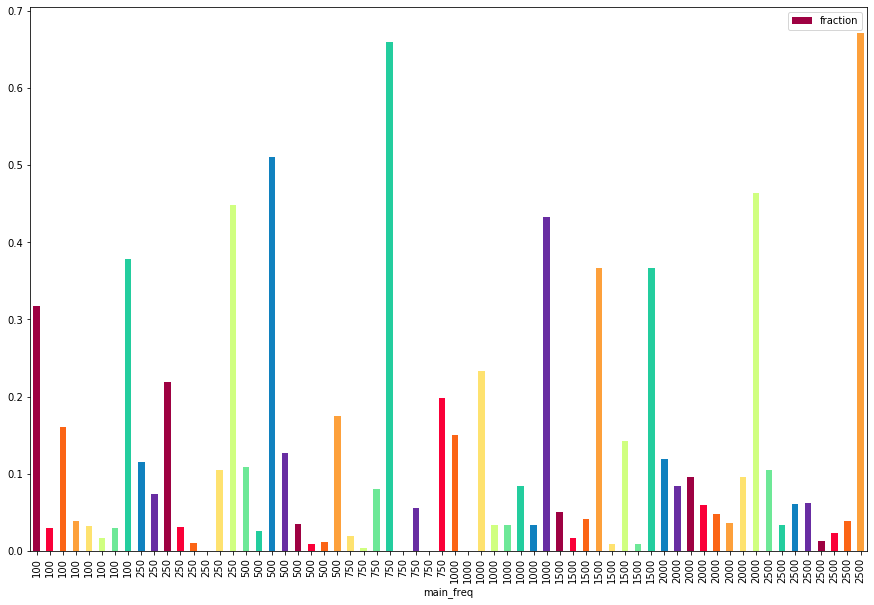

In [11]:
# plot results using barplot (does not look very good but helps in data inspection)
colors = [[158,1,66,255],[250,0,56,255],[251,100,21,255],[253,160,59,255],[254,226,111,255],[208,255,128,255],[109,232,151,255],[35,205,158,255],[16,129,191,255],[104,45,162,255]]
colors = [tuple(i/255 for i in item) for item in colors]

for brain_region, values in condensed_summary.items():
    print(brain_region)
    fig, ax = plt.subplots(figsize=(15,10))  
    
    labels = np.array([100, 250, 500, 750, 1000, 1500, 2000, 2500])
    if brain_region == 'TS':
        labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])
    
    values['mean']['freq'] = labels
    formatted_df = pd.melt(values['mean'],
                       ['freq'],
                       var_name='main_freq',
                       value_name='fraction')
    print(formatted_df)
    for row, freq in enumerate(labels):
        formatted_df.plot(kind='bar', x='main_freq',y='fraction', ax=ax, label=None, stacked=True, color=colors)
        plt.show()
    
    # uncomment line below if you wish to save a csv file with the formatted dataframe 
    #formatted_df.to_csv(folder_path + '\\' + brain_region +'_summary_raw_kNN_fractions.csv')

Cerebellum
    freq main_freq  fraction
0    100       100  0.054213
1    250       100  0.076078
2    500       100  0.078064
3    750       100  0.207169
4   1000       100  0.181829
..   ...       ...       ...
59   750      2500  0.212269
60  1000      2500  0.180218
61  1500      2500  0.235274
62  2000      2500  0.071367
63  2500      2500  0.100476

[64 rows x 3 columns]


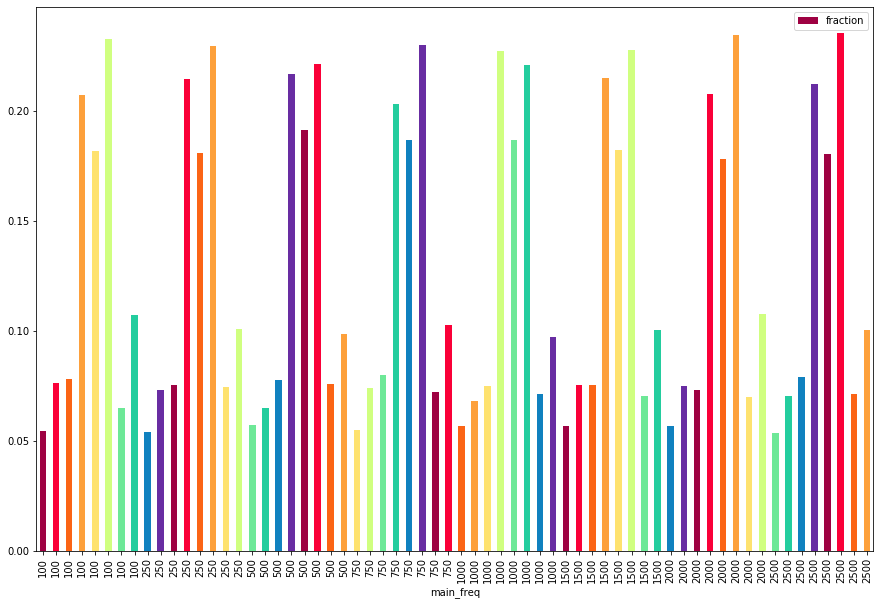

Hindbrain
    freq main_freq  fraction
0    100       100  0.071613
1    250       100  0.176537
2    500       100  0.061284
3    750       100  0.226929
4   1000       100  0.109499
..   ...       ...       ...
59   750      2500  0.226121
60  1000      2500  0.112094
61  1500      2500  0.198635
62  2000      2500  0.086701
63  2500      2500  0.069437

[64 rows x 3 columns]


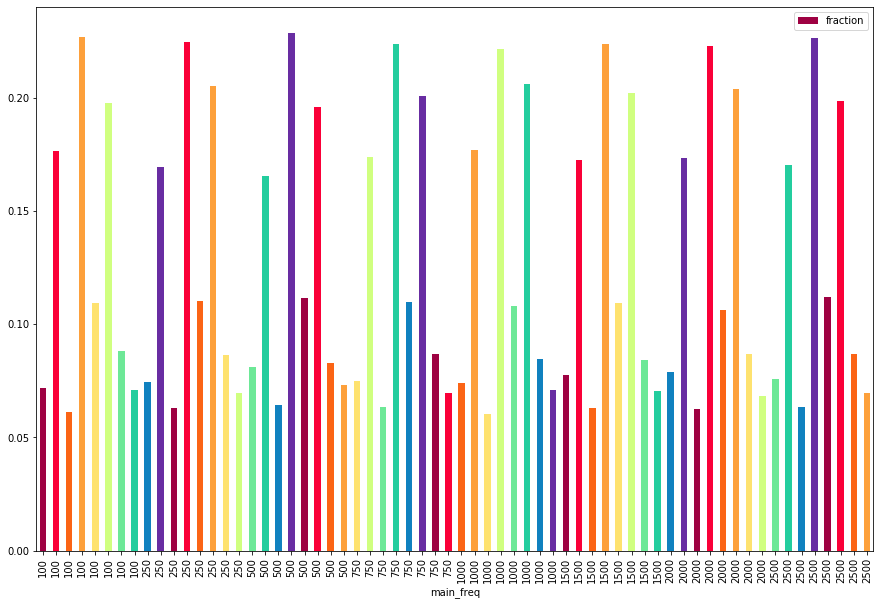

OLN
    freq main_freq  fraction
0    100       100  0.037290
1    250       100  0.233997
2    500       100  0.106117
3    750       100  0.294506
4   1000       100  0.081019
..   ...       ...       ...
59   750      2500  0.294856
60  1000      2500  0.078651
61  1500      2500  0.114851
62  2000      2500  0.050177
63  2500      2500  0.093225

[64 rows x 3 columns]


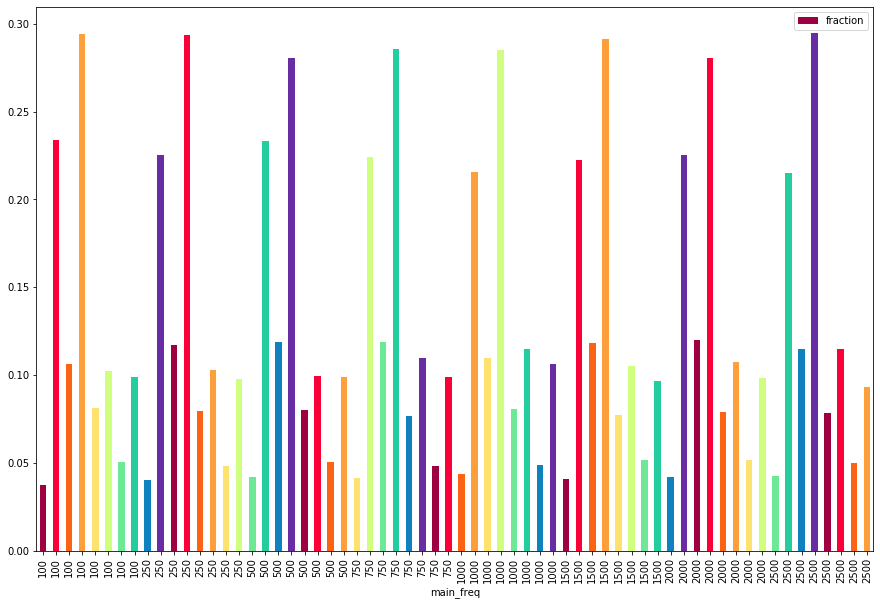

TS
    freq main_freq   fraction
0    100       100  0.0321231
1    250       100   0.290131
2    500       100  0.0469062
3    750       100    0.45814
4   1000       100  0.0255063
5   1500       100  0.0615338
6   2500       100  0.0866674
7    100       250  0.0303319
8    250       250   0.287592
9    500       250  0.0525496
10   750       250   0.464255
11  1000       250  0.0271098
12  1500       250  0.0554123
13  2500       250  0.0872237
14   100       500  0.0317645
15   250       500   0.274769
16   500       500  0.0406937
17   750       500   0.487516
18  1000       500  0.0231157
19  1500       500  0.0538607
20  2500       500  0.0917824
21   100       750  0.0311944
22   250       750   0.279989
23   500       750  0.0499755
24   750       750   0.468699
25  1000       750  0.0234322
26  1500       750  0.0581667
27  2500       750  0.0921595
28   100      1000  0.0353586
29   250      1000   0.278426
30   500      1000  0.0368317
31   750      1000   0.484999
32  100

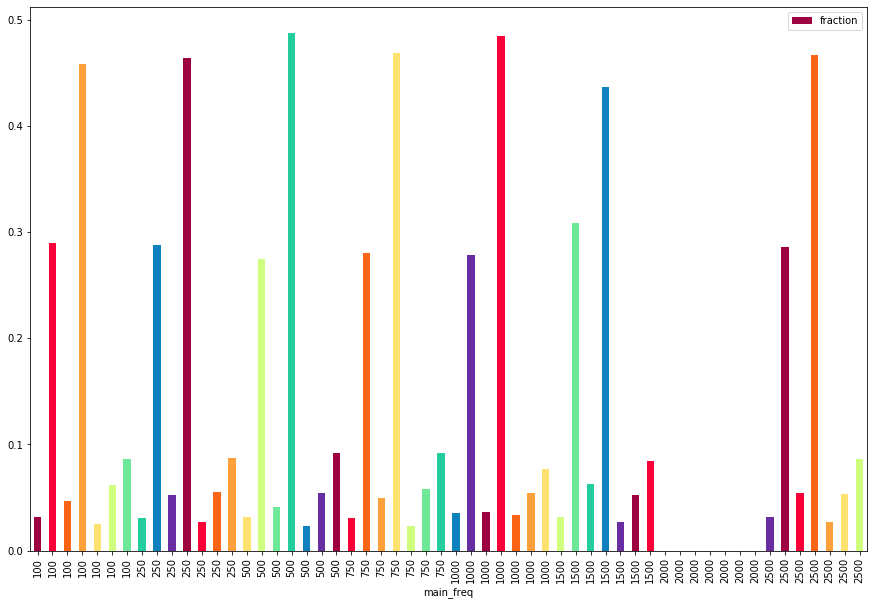

Tectum
    freq main_freq  fraction
0    100       100  0.088067
1    250       100  0.231216
2    500       100  0.144432
3    750       100  0.075115
4   1000       100  0.192922
..   ...       ...       ...
59   750      2500  0.068359
60  1000      2500  0.184534
61  1500      2500  0.036143
62  2000      2500  0.058927
63  2500      2500  0.174349

[64 rows x 3 columns]


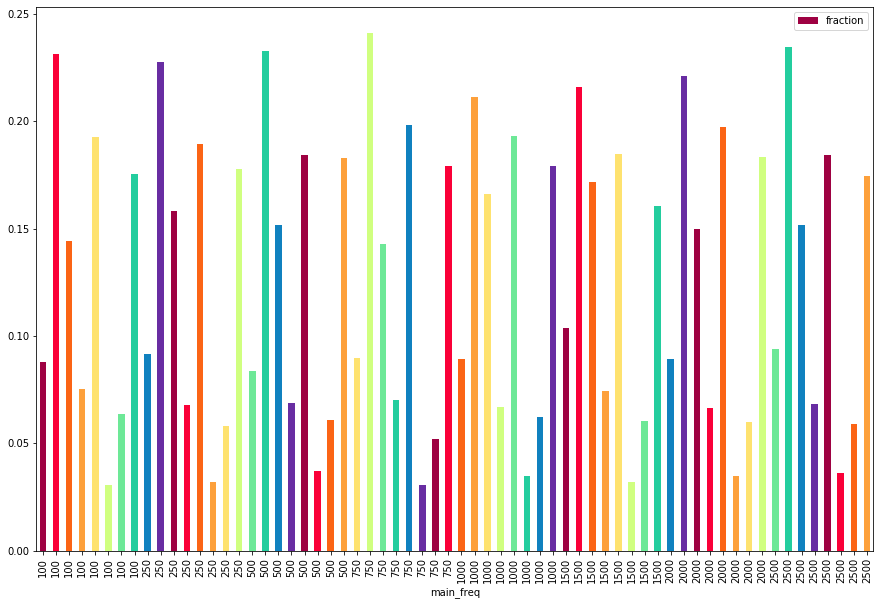

Tegmentum
    freq main_freq  fraction
0    100       100  0.036774
1    250       100  0.065034
2    500       100  0.060051
3    750       100  0.231596
4   1000       100  0.170737
..   ...       ...       ...
59   750      2500  0.232132
60  1000      2500  0.196716
61  1500      2500  0.311576
62  2000      2500  0.058308
63  2500      2500  0.024891

[64 rows x 3 columns]


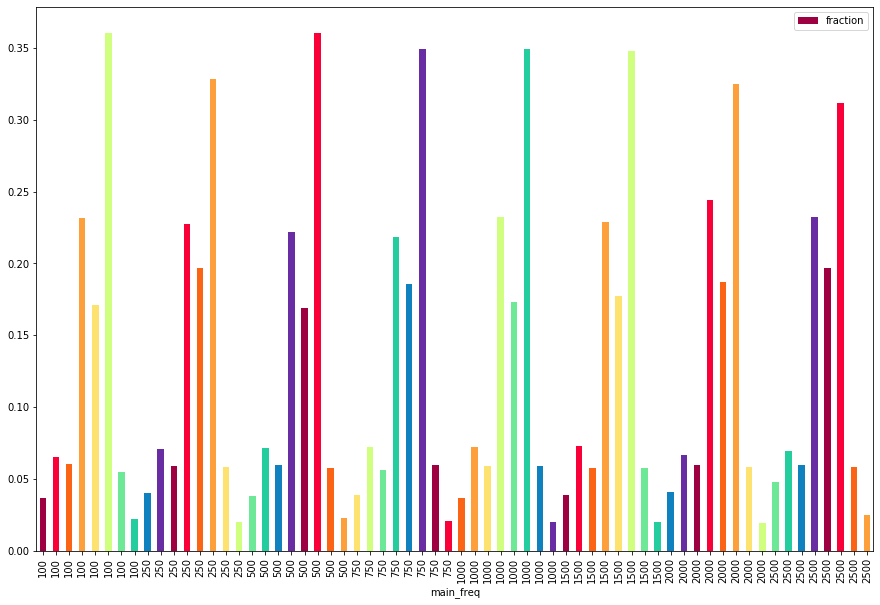

Telencephalon
    freq main_freq  fraction
0    100       100  0.124690
1    250       100  0.027391
2    500       100  0.167762
3    750       100  0.143996
4   1000       100  0.017976
..   ...       ...       ...
59   750      2500  0.151022
60  1000      2500  0.017775
61  1500      2500  0.031357
62  2000      2500  0.031477
63  2500      2500  0.477885

[64 rows x 3 columns]


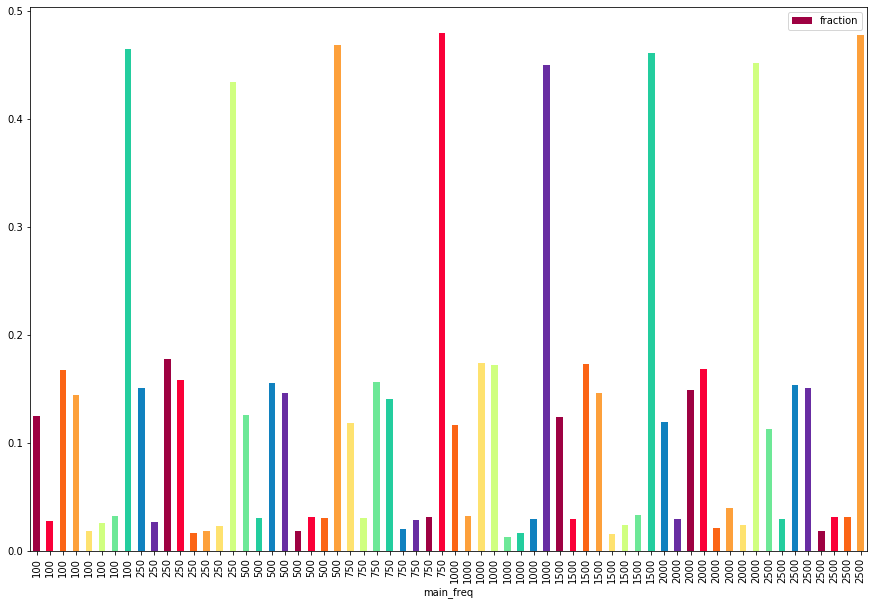

In [12]:
# plot results using barplot (again, it does not look very good but helps in data inspection)
colors = [[158,1,66,255],[250,0,56,255],[251,100,21,255],[253,160,59,255],[254,226,111,255],[208,255,128,255],[109,232,151,255],[35,205,158,255],[16,129,191,255],[104,45,162,255]]
colors = [tuple(i/255 for i in item) for item in colors]

for brain_region, values in condensed_rand_summary.items():
    print(brain_region)
    fig, ax = plt.subplots(figsize=(15,10))  
    labels = np.array([100, 250, 500, 750, 1000, 1500, 2000, 2500])
    if brain_region == 'TS':
        labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])
    
    values['mean']['freq'] = labels
    formatted_df = pd.melt(values['mean'],
                       ['freq'],
                       var_name='main_freq',
                       value_name='fraction')
    print(formatted_df)
    for row, freq in enumerate(labels):
        formatted_df.plot(kind='bar', x='main_freq',y='fraction', ax=ax, label=None, stacked=True, color=colors)
        plt.show()
    # uncomment line below if you wish to save a csv file with the formatted dataframe 
    #formatted_df.to_csv(folder_path + '\\' + brain_region +'_summary_random_'+ str(n_iter) +'_kNN_fractions_newmethod2.csv') 